### Simulate LP Activity using GBM
* https://medium.com/@chiqing/uniswap-v2-explained-beginner-friendly-b5d2cb64fe0f

In [1]:
import os
import copy
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from IPython.display import Image
cwd =  os.getcwd().replace("notebooks/research/impermanent_loss","")
os.chdir(cwd)

from python.dev.cpt import SolveDeltas
from python.dev.math.model import BrownianModel
from python.dev.cpt import Liquidity
from python.dev.cpt import LiquidityPoolUSD
from python.dev.math.model import EventSelectionModel
from python.dev.math.model import TokenDeltaModel

In [2]:
from python.dev.simulation import SimulateLiquidity
from python.dev.simulation import SimLPFees

**Simulate prices**

In [105]:
p_arr[-1,]

array([0.21924946, 0.6233603 , 0.40078637, 0.33926744, 0.34162361,
       0.4682282 , 0.11206096, 0.19395061, 0.45584834, 0.19932339,
       0.46776801, 0.20201539, 0.57710089, 0.44368966, 0.27638115,
       0.09562744, 0.36890122, 0.11409941, 0.21687757, 0.42632954,
       0.22473839, 0.25275536, 0.262619  , 0.27833599, 0.34931123])

In [110]:

100*np.sqrt(np.var(exp_p_arr))

2.3360121421290128

chg mu 39.168% chg sig 10.729%


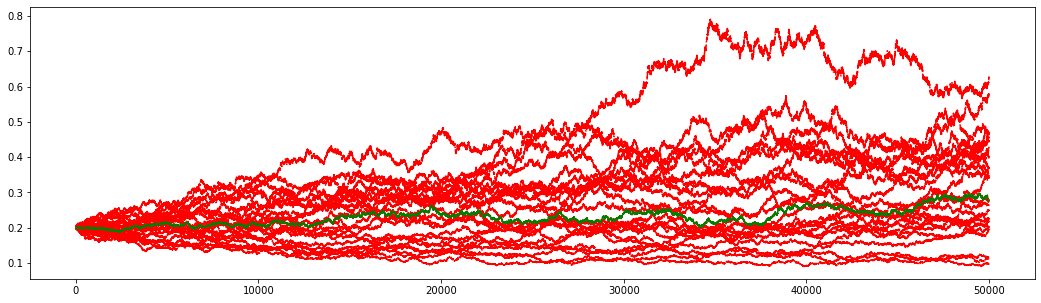

In [85]:
n_steps = 50000
start_price = 0.2
mu = 0.4; sigma = 0.5
#mu = 0.4; sigma = 0.1
n_paths = 25

b = BrownianModel(start_price)
p_arr = b.gen_gbms(mu, sigma, n_steps, n_paths)
exp_p_arr = np.median(p_arr, axis = 1)

x_val = np.arange(0,len(p_arr))
fig, (USD_ax) = plt.subplots(nrows=1, sharex=False, sharey=False, figsize=(18, 5))
USD_ax.plot(p_arr, color = 'r',linestyle = 'dashdot', label='initial invest') 
USD_ax.plot(exp_p_arr, color = 'g',linestyle = 'dashed', label='initial invest') 

per_chg_sig = 100*np.sqrt(np.var(p_arr))
per_chg_mu = 100*(exp_p_arr[-1]-exp_p_arr[0])/exp_p_arr[0]
print('chg-mu {:.3f}% chg-sig {:.3f}%'.format(per_chg_mu, per_chg_sig))

**Calculate LP holdings using simulated prices**

In [86]:
lp_sims = {}
tdel = TokenDeltaModel(10000) 

for k in range(n_paths):
    liq = Liquidity(100000, 20000, 'SYS','DIA')
    simLiq = SimulateLiquidity(liq, tdel)
    simLiq.run(p_arr[:,k], lp_rate = 0.55)
    simLiq.check(p_arr[:,k], 10000)
    lp_sims[k] = {}
    lp_sims[k]['sim_liq'] = simLiq  

raw: 0.1283347 y/x: 0.1283350 dy/dx: 0.1285236 liq: 821156.3008464
raw: 0.3353892 y/x: 0.3365857 dy/dx: 0.3357046 liq: 979524.8082850
raw: 0.2104192 y/x: 0.2108651 dy/dx: 0.2109025 liq: 775966.9670473
raw: 0.2060455 y/x: 0.2060465 dy/dx: 0.2067550 liq: 1097774.1211993
raw: 0.2019909 y/x: 0.2022500 dy/dx: 0.2024031 liq: 853092.4986301
raw: 0.2092240 y/x: 0.2095126 dy/dx: 0.2092646 liq: 871703.0864743
raw: 0.1364159 y/x: 0.1364153 dy/dx: 0.1360031 liq: 865734.1246329
raw: 0.2620304 y/x: 0.2632216 dy/dx: 0.2627093 liq: 1230437.5025276
raw: 0.3457433 y/x: 0.3459773 dy/dx: 0.3473447 liq: 1125909.8191120
raw: 0.1687511 y/x: 0.1687542 dy/dx: 0.1691725 liq: 1038837.7131377
raw: 0.2128681 y/x: 0.2129614 dy/dx: 0.2130610 liq: 951063.0364527
raw: 0.2101948 y/x: 0.2102080 dy/dx: 0.2086695 liq: 941732.8338359
raw: 0.3021823 y/x: 0.3047313 dy/dx: 0.3049988 liq: 990557.0625843
raw: 0.3217218 y/x: 0.3229462 dy/dx: 0.3212647 liq: 980187.9212855
raw: 0.2373703 y/x: 0.2383295 dy/dx: 0.2383582 liq: 102883

**Determine valuations from LP position**

In [87]:
start_pt = 0
init_pos_sys = 10000
init_pos_dai = p_arr[start_pt,0]*init_pos_sys

for k in range(n_paths):
    simLiq = lp_sims[k]['sim_liq']
    sys_arr = simLiq.get_x_arr()
    dai_arr = simLiq.get_y_arr()

    lpVal = LiquidityPoolUSD(sys_arr, dai_arr, p_arr[:,k])
    lp_sims[k]['lp_val'] = lpVal
    lp_sims[k]['hodl_usd'] = lpVal.hodl_position_usd(init_pos_sys, init_pos_dai, start_pt)
    lp_sims[k]['lp_pos'] = lpVal.lp_position_usd(init_pos_sys, init_pos_dai, start_pt)


**Determine collected fees from LP position**

In [88]:
for k in range(n_paths):
    simLiq = lp_sims[k]['sim_liq']
    lpVal = lp_sims[k]['lp_val']
    
    dai_arr = simLiq.get_y_arr()
    
    simFees = SimLPFees(simLiq, lpVal)
    lp_pos_fees = simFees.lp_position_fees_usd(init_pos_sys, init_pos_dai, start_pt)
    percent_returns = simFees.position_percent_returns(init_pos_sys, init_pos_dai, start_pt)
    
    lp_sims[k]['lp_pos_fees'] = lp_pos_fees
    lp_sims[k]['percent_returns'] = percent_returns
    
    print('percent returns: {:.3f}%'.format(100*percent_returns[-1]))
    print('collected fees:  ${:.2f}\n'.format(lp_pos_fees[-1]))
    

percent returns: 10.786%
collected fees:  $431.44

percent returns: 17.770%
collected fees:  $710.81

percent returns: 15.427%
collected fees:  $617.08

percent returns: 13.542%
collected fees:  $541.70

percent returns: 12.669%
collected fees:  $506.75

percent returns: 13.120%
collected fees:  $524.79

percent returns: 10.113%
collected fees:  $404.52

percent returns: 11.799%
collected fees:  $471.97

percent returns: 14.504%
collected fees:  $580.17

percent returns: 10.942%
collected fees:  $437.66

percent returns: 13.548%
collected fees:  $541.91

percent returns: 11.190%
collected fees:  $447.59

percent returns: 14.897%
collected fees:  $595.89

percent returns: 17.317%
collected fees:  $692.69

percent returns: 13.308%
collected fees:  $532.33

percent returns: 11.727%
collected fees:  $469.09

percent returns: 12.803%
collected fees:  $512.12

percent returns: 9.522%
collected fees:  $380.88

percent returns: 14.146%
collected fees:  $565.85

percent returns: 15.756%
collect

**Plots**

In [89]:
per_returns = np.zeros((n_steps, n_paths), np.float64)
lp_pos_fees = np.zeros((n_steps, n_paths), np.float64)
lp_pos = np.zeros((n_steps, n_paths), np.float64)
tot_lp_pos = np.zeros((n_steps, n_paths), np.float64)
hodl_usd = np.zeros((n_steps, n_paths), np.float64)
for k in range(0, n_paths):
    per_returns[:,k] = lp_sims[k]['percent_returns']
    lp_pos_fees[:,k] = lp_sims[k]['lp_pos_fees']
    hodl_usd[:,k] = lp_sims[k]['hodl_usd'][1:]
    lp_pos[:,k] = lp_sims[k]['lp_pos'][1:]
    tot_lp_pos[:,k] = lp_pos[:,k] + lp_pos_fees[:,k]

In [97]:
exp_per_returns = np.median(per_returns, axis = 1)
exp_lp_pos = np.median(lp_pos_tot, axis = 1)
exp_hodl_usd = np.median(hodl_usd, axis = 1)
exp_tot_lp_pos = np.median(tot_lp_pos, axis = 1)

sig_p_arr = np.sqrt(np.var(p_arr))
sig_p_arr

0.10728900626962887

In [112]:
IL = (exp_lp_pos[-1] - exp_hodl_usd[-1])/exp_hodl_usd[-1]
IL

-0.10138970580343601

In [113]:
exp_lp_pos[-1]

4298.376476937263

In [116]:
10000*0.27 + 2000

4700.0

In [93]:
exp_hodl_usd[-1]

4783.359933329482

In [94]:
exp_per_returns[-1]

0.13119756982313574

Text(0.5, 0, 'Time')

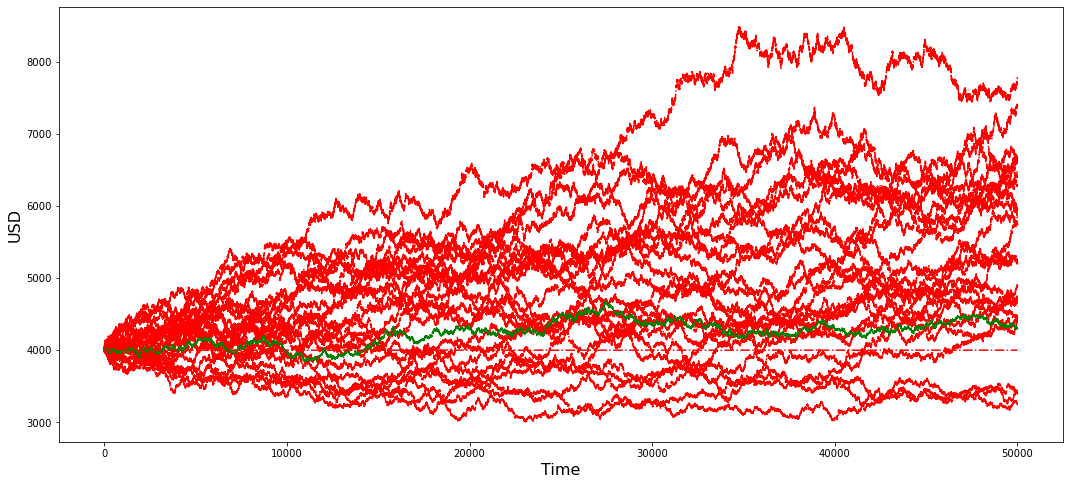

In [95]:
initial_usd = 2*init_pos_dai

fig, (USD_ax) = plt.subplots(nrows=1, sharex=False, sharey=False, figsize=(18, 8))
USD_ax.plot(tot_lp_pos, color = 'r',linestyle = 'dashdot', label='initial invest') 
USD_ax.plot(exp_lp_pos, color = 'g',linestyle = 'dashed', label='initial invest') 
USD_ax.plot(np.repeat(initial_usd, n_steps), color = 'r',linestyle = 'dashdot', label='initial invest') 
USD_ax.set_ylabel("USD", fontsize=16)
USD_ax.set_xlabel('Time', fontsize=16)


Text(0.5, 0, 'Time')

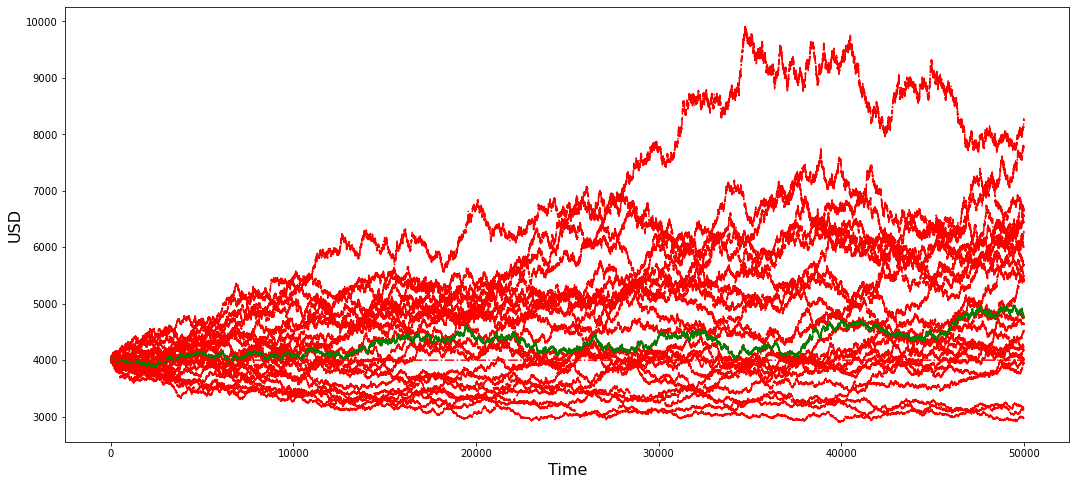

In [96]:
fig, (USD_ax) = plt.subplots(nrows=1, sharex=False, sharey=False, figsize=(18, 8))
USD_ax.plot(hodl_usd, color = 'r',linestyle = 'dashdot', label='initial invest') 
USD_ax.plot(exp_hodl_usd, color = 'g',linestyle = 'dashed', label='initial invest') 
USD_ax.plot(np.repeat(initial_usd, n_steps), color = 'r',linestyle = 'dashdot', label='initial invest') 
USD_ax.set_ylabel("USD", fontsize=16)
USD_ax.set_xlabel('Time', fontsize=16)


In [ ]:
initial_usd = 2*p_arr[0]*init_pos_sys

x_val = np.arange(0,len(p_arr[1:,0]))
fig, (USD_ax, fee_ax) = plt.subplots(nrows=2, sharex=False, sharey=False, figsize=(18, 10))
USD_ax.plot(x_val, np.repeat(initial_usd, len(p_arr)), color = 'r',linestyle = 'dashdot', label='initial invest') 
USD_ax.plot(x_val[1:], lp_pos[1:] + lp_pos_fees, color = 'g',label='lp invest + fees') 
USD_ax.plot(x_val[1:], lp_pos[1:], color = 'r',label='lp invest') 
USD_ax.set_title("Position: Value (USD)", fontsize=20)
USD_ax.set_ylabel("USD", fontsize=16)
USD_ax.set_xlabel('Time', fontsize=16)
USD_ax.legend()

fee_ax.plot(x_val[1:], lp_pos_fees, color = 'r',label='fees USD') 
fee_ax.set_title("Position: Collected Fees (USD)", fontsize=20)
fee_ax.set_ylabel("USD", fontsize=16)
fee_ax.set_xlabel('Time', fontsize=16)
fee_ax.legend()


In [ ]:
fig, (SYS_ax, DAI_ax, USD_ax, price_ax) = plt.subplots(nrows=4, sharex=False, sharey=False, figsize=(18, 20))
SYS_ax.plot(sys_arr, color = 'b',label='sys2') 
SYS_ax.set_title("USER1: LP Total (SYS)", fontsize=20)
SYS_ax.set_ylabel("SYS", fontsize=16)
SYS_ax.legend()

DAI_ax.plot(dai_arr, color = 'b',label='dai2') 
DAI_ax.set_title("USER1: LP Total (DAI)", fontsize=20)
DAI_ax.set_ylabel("DIA", fontsize=16)
DAI_ax.legend()

USD_ax.plot(usd_arr, color = 'b',label='usd2') 
USD_ax.set_title("USER1: LP Total (USD)", fontsize=20)
USD_ax.set_ylabel("USD", fontsize=16)
USD_ax.legend()

price_ax.plot(p_arr, label='price orig') 
price_ax.set_title("USER1: SYS_DAI_LP Prices", fontsize=20)
price_ax.set_ylabel("SYSDIA", fontsize=16)
price_ax.set_xlabel('Time', fontsize=16)
price_ax.legend()